In [19]:
import tensorflow as tf
import numpy as np
import scipy.signal
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import PIL.Image

import random
import matplotlib.ticker as ticker
import cv2
import tensorflow_datasets as tfds
print('TensorFlow version:', tf.__version__)
print('NumPy version: ', np.__version__)


TensorFlow version: 2.12.0
NumPy version:  1.22.4


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Question: 1

In [ ]:
!unzip '/content/archive(3).zip'

In [42]:
batch_size = 32
img_height = 180
img_width = 180
NUM_EPOCHS = 10
steps_per_epoch = 20


In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  '/content/seg_train/seg_train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 14034 files belonging to 6 classes.
Using 11228 files for training.


In [30]:
val_ds = tf.keras.utils.image_dataset_from_directory(
 '/content/seg_train/seg_train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [23]:
class_names = train_ds.class_names
print(class_names)


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


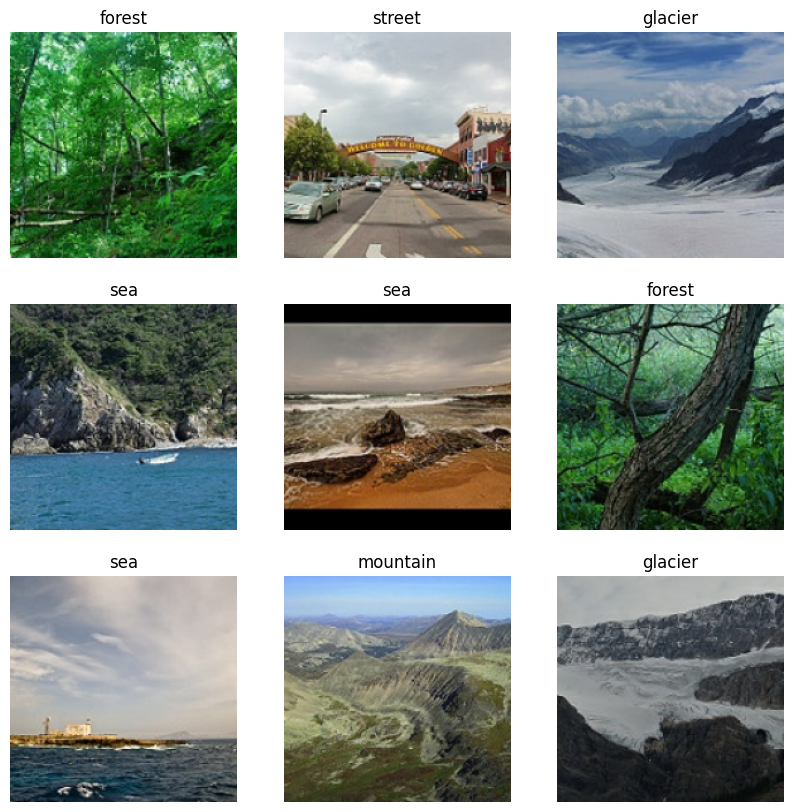

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [25]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break
# There are 3 color channels as evident from the shape

(64, 180, 180, 3)
(64,)


Question: 2

In [26]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 0.9670752


Question: 3

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [33]:
num_classes = 6

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [45]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 41, 41, 32)       

In [34]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])


In [38]:
model.fit(train_ds,validation_data=val_ds,epochs=10)


Epoch 1/10
176/176 [==============================] - 8s 48ms/step - loss: 0.4323 - accuracy: 0.8469 - val_loss: 0.6302 - val_accuracy: 0.7833
Epoch 2/10
176/176 [==============================] - 9s 49ms/step - loss: 0.3383 - accuracy: 0.8819 - val_loss: 0.7534 - val_accuracy: 0.7641
Epoch 3/10
176/176 [==============================] - 9s 49ms/step - loss: 0.2585 - accuracy: 0.9109 - val_loss: 0.8785 - val_accuracy: 0.7637
Epoch 4/10
176/176 [==============================] - 8s 45ms/step - loss: 0.2083 - accuracy: 0.9241 - val_loss: 0.8929 - val_accuracy: 0.7502
Epoch 5/10
176/176 [==============================] - 9s 48ms/step - loss: 0.1816 - accuracy: 0.9388 - val_loss: 0.8519 - val_accuracy: 0.7676
Epoch 6/10
176/176 [==============================] - 8s 45ms/step - loss: 0.1550 - accuracy: 0.9465 - val_loss: 0.9590 - val_accuracy: 0.7648
Epoch 7/10
176/176 [==============================] - 9s 50ms/step - loss: 0.1055 - accuracy: 0.9663 - val_loss: 1.0376 - val_accuracy: 0.7634

In [43]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, steps_per_epoch=20)

Epoch 1/10
20/20 [==============================] - 2s 84ms/step - loss: 0.0259 - accuracy: 0.9937 - val_loss: 1.3397 - val_accuracy: 0.7698
Epoch 2/10
20/20 [==============================] - 2s 79ms/step - loss: 0.0215 - accuracy: 0.9945 - val_loss: 1.2281 - val_accuracy: 0.7726
Epoch 3/10
20/20 [==============================] - 2s 78ms/step - loss: 0.0267 - accuracy: 0.9914 - val_loss: 1.4063 - val_accuracy: 0.7623
Epoch 4/10
20/20 [==============================] - 2s 110ms/step - loss: 0.0492 - accuracy: 0.9852 - val_loss: 1.4455 - val_accuracy: 0.7573
Epoch 5/10
20/20 [==============================] - 2s 111ms/step - loss: 0.0332 - accuracy: 0.9906 - val_loss: 1.4136 - val_accuracy: 0.7623
Epoch 6/10
20/20 [==============================] - 2s 79ms/step - loss: 0.0340 - accuracy: 0.9922 - val_loss: 1.5144 - val_accuracy: 0.7512
Epoch 7/10
20/20 [==============================] - 2s 78ms/step - loss: 0.0451 - accuracy: 0.9867 - val_loss: 1.7664 - val_accuracy: 0.7352
Epoch 8/10


20/20 [==============================] - 1s 67ms/step - loss: 0.0290 - accuracy: 0.9929 - val_loss: 1.3786 - val_accuracy: 0.7623


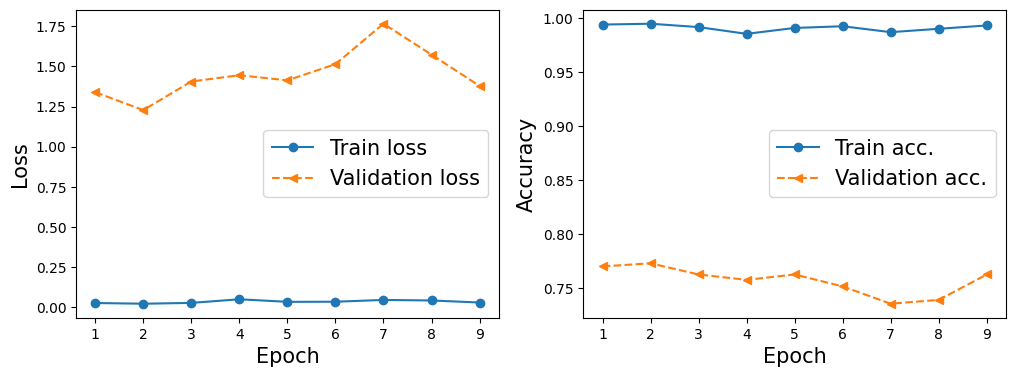

In [44]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
#plt.savefig('figures/15_18.png', dpi=300)
plt.show()


Question: 4

In [52]:
model_regularization = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
  
])



In [56]:
from keras import regularizers
model_regularization.get_layer('dense_10').kernel_regularizer = tf.keras.regularizers.L2(2.)


In [57]:
model_regularization.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [58]:
model_regularization.fit(train_ds,validation_data=val_ds,epochs=10)

Epoch 1/10
176/176 [==============================] - 11s 49ms/step - loss: 9.2075 - accuracy: 0.5473 - val_loss: 2.2218 - val_accuracy: 0.6080
Epoch 2/10
176/176 [==============================] - 8s 45ms/step - loss: 1.3218 - accuracy: 0.6426 - val_loss: 0.9680 - val_accuracy: 0.6732
Epoch 3/10
176/176 [==============================] - 8s 47ms/step - loss: 0.8955 - accuracy: 0.6876 - val_loss: 0.8427 - val_accuracy: 0.7142
Epoch 4/10
176/176 [==============================] - 8s 46ms/step - loss: 0.7860 - accuracy: 0.7272 - val_loss: 0.7719 - val_accuracy: 0.7341
Epoch 5/10
176/176 [==============================] - 9s 49ms/step - loss: 0.7109 - accuracy: 0.7593 - val_loss: 0.7096 - val_accuracy: 0.7502
Epoch 6/10
176/176 [==============================] - 8s 46ms/step - loss: 0.6657 - accuracy: 0.7789 - val_loss: 0.7020 - val_accuracy: 0.7691
Epoch 7/10
176/176 [==============================] - 9s 53ms/step - loss: 0.6352 - accuracy: 0.7910 - val_loss: 0.6938 - val_accuracy: 0.766

In [59]:
history = model.fit(train_ds, validation_data=val_ds, epochs=10, steps_per_epoch=20)

Epoch 1/10
20/20 [==============================] - 2s 121ms/step - loss: 0.0217 - accuracy: 0.9984 - val_loss: 1.3535 - val_accuracy: 0.7662
Epoch 2/10
20/20 [==============================] - 2s 80ms/step - loss: 0.0219 - accuracy: 0.9961 - val_loss: 1.3414 - val_accuracy: 0.7651
Epoch 3/10
20/20 [==============================] - 2s 80ms/step - loss: 0.0401 - accuracy: 0.9875 - val_loss: 1.6178 - val_accuracy: 0.7441
Epoch 4/10
20/20 [==============================] - 2s 108ms/step - loss: 0.0795 - accuracy: 0.9727 - val_loss: 1.5332 - val_accuracy: 0.7302
Epoch 5/10
20/20 [==============================] - 2s 79ms/step - loss: 0.0334 - accuracy: 0.9883 - val_loss: 1.3446 - val_accuracy: 0.7627
Epoch 6/10
20/20 [==============================] - 2s 78ms/step - loss: 0.0369 - accuracy: 0.9891 - val_loss: 1.5683 - val_accuracy: 0.7573
Epoch 7/10
20/20 [==============================] - 2s 79ms/step - loss: 0.0516 - accuracy: 0.9867 - val_loss: 1.7888 - val_accuracy: 0.7370
Epoch 8/10


20/20 [==============================] - 1s 74ms/step - loss: 0.0323 - accuracy: 0.9919 - val_loss: 1.4539 - val_accuracy: 0.7455


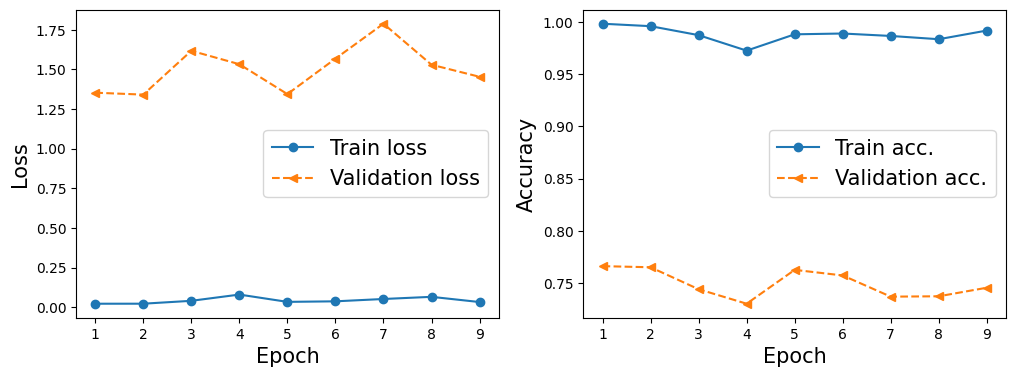

In [60]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
#plt.savefig('figures/15_18.png', dpi=300)
plt.show()